# Decision tree

In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [3]:
# Read csv, StaterData
df = pd.read_csv('/Users/laurensheberle/Github/StaterData.csv')

### The main model

In [4]:
# Define your features and target, with x as text_column which contains the complaint in the dataset. And target_column which contains the target variable
X = df['Clean consumer complaint']  
y = df['Issue']                        

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Vectorize your text data using a bag-of-words approach
vectorizer = TfidfVectorizer(stop_words='english',token_pattern=r'\b[a-zA-Z]+\b')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()
class_names = df['Issue']

#Gridsearch Define the parameter grid
best_params = {
    'criterion': 'gini',
    'max_depth': 14,
    'min_samples_split': 2,
    'min_samples_leaf': 1
    }

# Create a Decision tree model
model = DecisionTreeClassifier(random_state=2, **best_params)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.4754368716501221


In [5]:
# The classification_report
print(classification_report(y_test, y_pred, zero_division=0))

                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.17      0.02      0.04      1095
                     Applying for a mortgage or refinancing an existing mortgage       0.45      0.45      0.45      3272
                                                           Closing on a mortgage       0.39      0.32      0.35      2241
                                                  Credit decision / Underwriting       0.04      0.01      0.01       384
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        10
                                                     Improper use of your report       0.00      0.00      0.00        61
                                            Incorrect information on your report       0.36      0.11      0.17       434
                       

Precision: represents the ability of the classifier to avoid false positive predictions. Higher precision values indicate a lower rate of false positives.

Recall: represents the proportion of actual positive instances that are correctly classified. Higher recall values indicate a lower rate of false negatives.

F1-score: The F1-score ranges from 0 to 1, where a value of 1 indicates perfect precision and recall, and 0 indicates poor performance.

Support: The support is the number of samples or instances of each class in the test set.

### Gridsearch

For finding the optimal hyperparameters i ran the script below, and then put the best hyperparameters in the final model above.

In [6]:
# # Define your features and target, with x as text_column which contains the complaint in the dataset. And target_column which contains the target variable
# X = df['Clean consumer complaint']  
# y = df['Issue']                        

# # Split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# # Vectorize your text data using a bag-of-words approach
# vectorizer = TfidfVectorizer(stop_words='english',token_pattern=r'\b[a-zA-Z]+\b')
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)

# # Gridsearch Define the parameter grid
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10,11,12,3,14,15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a decision tree classifier
# model = DecisionTreeClassifier(random_state=2)

# # Gridsearch create a GridSearchCV object and fit it to the data
# grid_search = GridSearchCV(model, param_grid)
# grid_search.fit(X_train, y_train)


# # Print the best hyperparameters and the corresponding score
# print("Best Hyperparameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

## Finding the optimal depth for the decision tree to validate the gridsearch parameter

For finding the optimal depth of the decision tree i ran the script below, and then put that depth in de final tree in the final model above.



In [7]:
# # List of values to try for max_depth:
# max_depth_range = list(range(1, 20))
# # List to store the accuracy for each value of max_depth:
# accuracy = []
# for depth in max_depth_range:
    
#     model = DecisionTreeClassifier(max_depth = depth, 
#                                  random_state = 2)
#     model.fit(X_train, y_train)
#     score = model.score(X_test, y_test)
#     accuracy.append(score)

# max_accuracy = max(accuracy)
# max_depth = max_depth_range[accuracy.index(max_accuracy)]
# print("Max accuracy:", max_accuracy)
# print("Corresponding max depth:", max_depth)

In [8]:
# Import the f1 score and show how good the model is.
f1 = f1_score(y_test, model.predict(X_test),average='macro')
f1

0.19558023385048492

<function matplotlib.pyplot.show(close=None, block=None)>

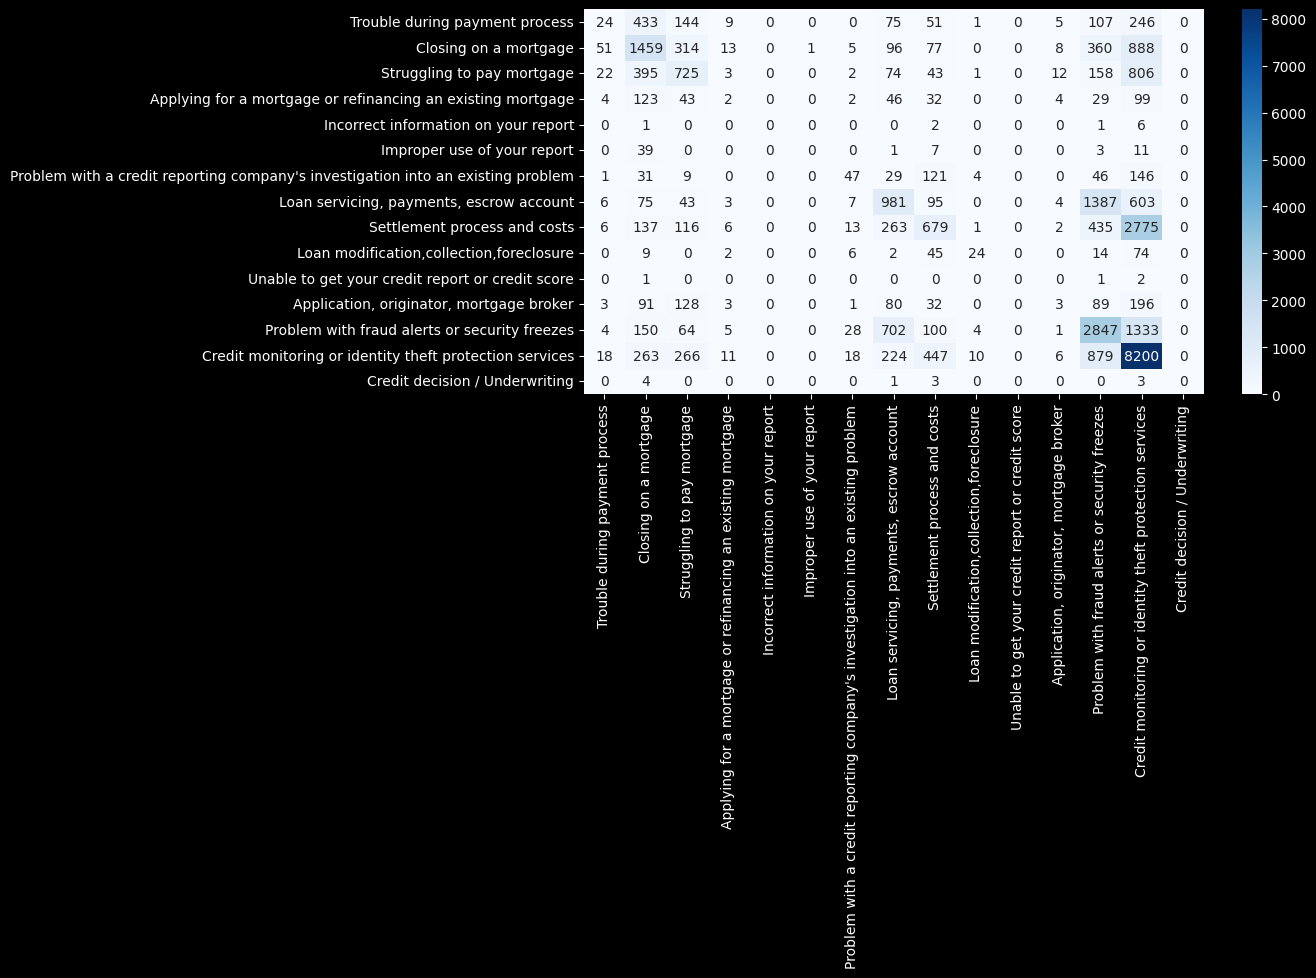

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred,)

# Plot the confusion matrix using Seaborn heatmap
labels = df['Issue'].unique()

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d" ,xticklabels=labels, yticklabels=labels)

plt.show


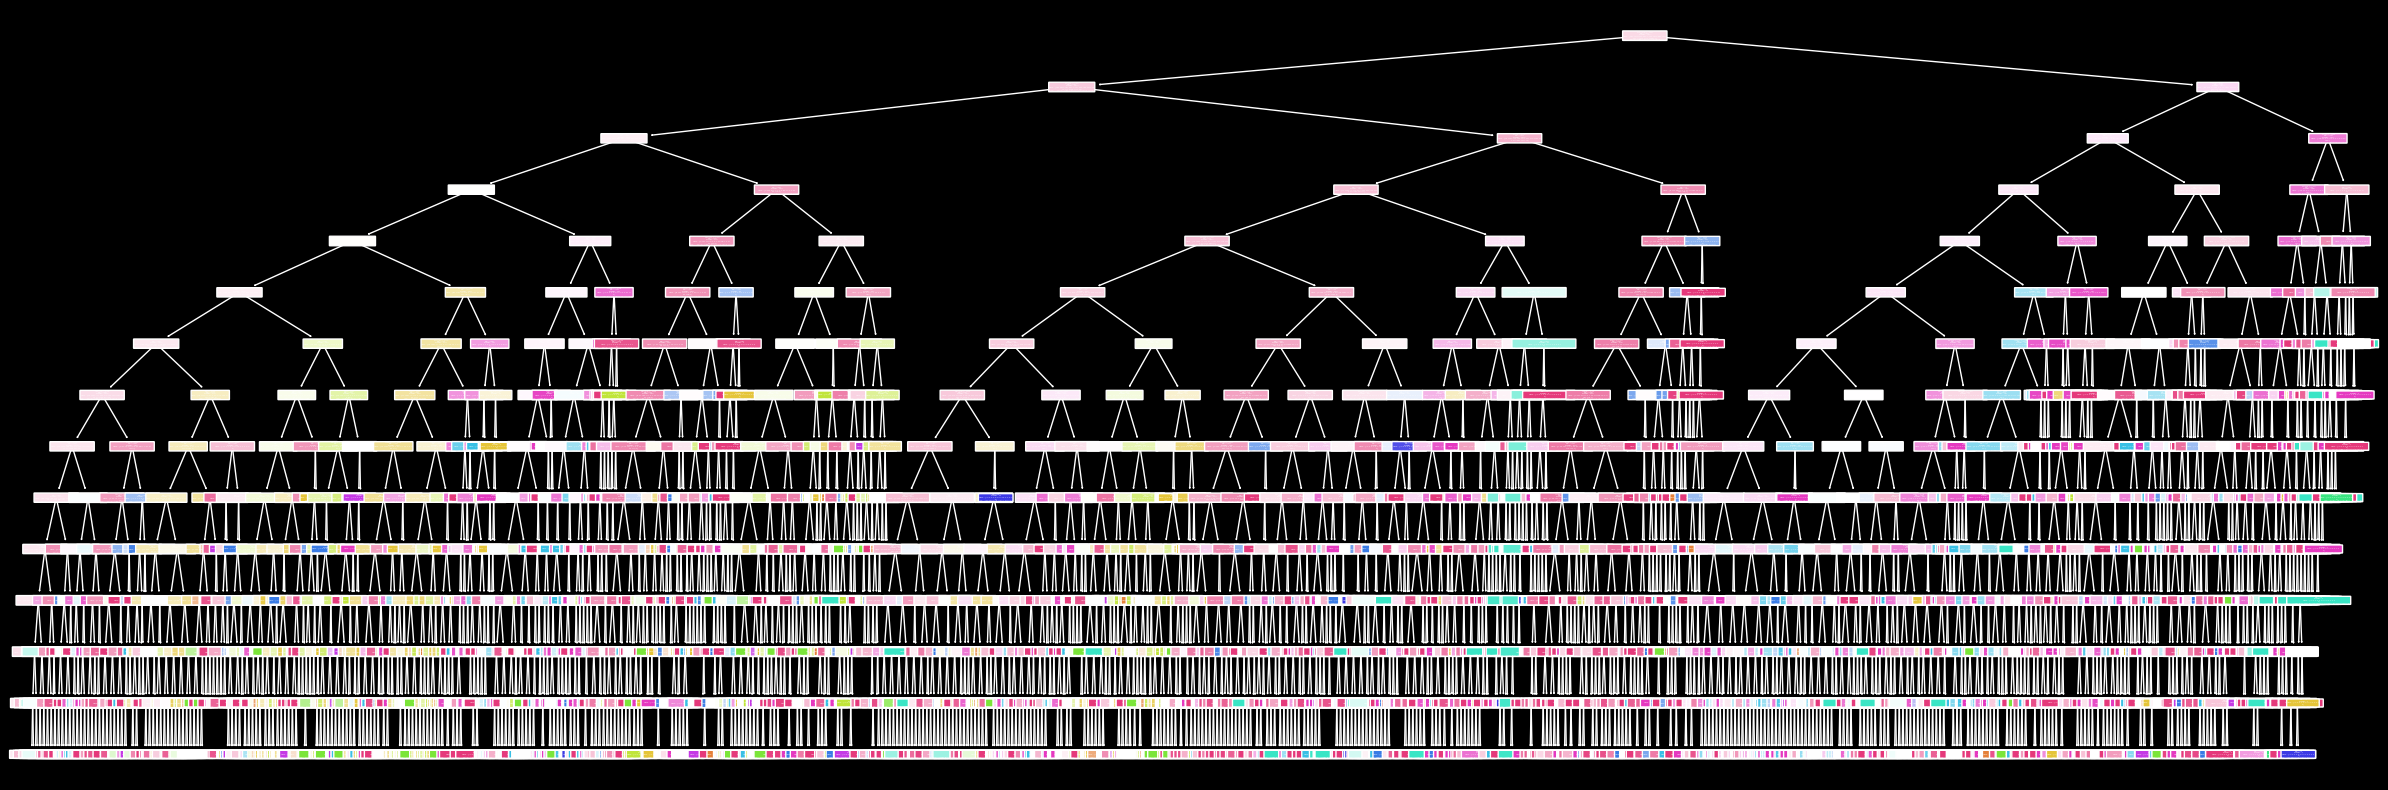

In [10]:
# Visualize original decision tree

plt.figure(figsize=(30, 10))
tree = plot_tree(model, filled=True, max_depth=14, class_names=labels, feature_names=feature_names, rounded=True)
plt.show(tree)



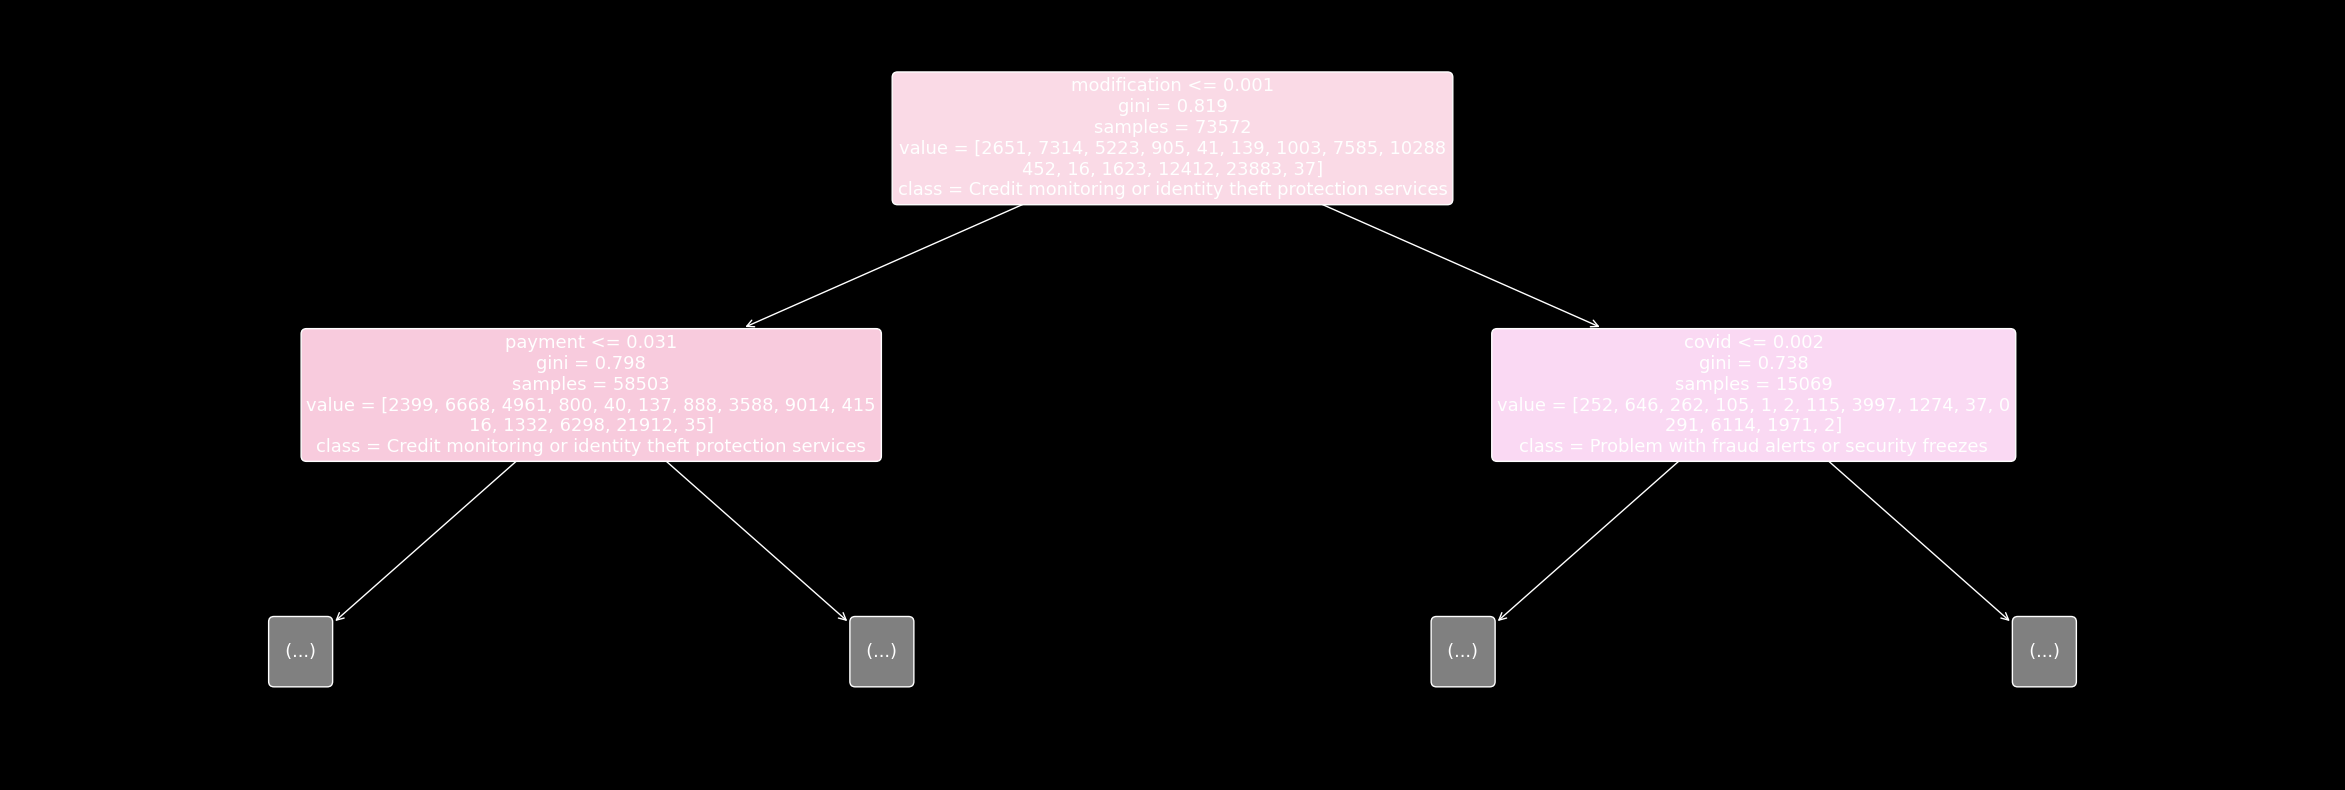

In [13]:
# Visualize first layer of the original decision tree

plt.figure(figsize=(30, 10))
tree = plot_tree(model, filled=True, max_depth=1, class_names=labels, feature_names=feature_names, rounded=True)
plt.show(tree)


## The conclusion


The Decision tree model accuracy is Accuracy: 0.4754368716501221 just slightly better than someone randomly guessing which issue belongs to the complaint.
The most information is gained with the word 'modification', it is on the top of the decision tree, that is where most information is gained. Splitting in the 2 words of 'payment' and 'covid'.

With depth '14' being the optimal depthe for the decision tree, it is the balance between the complexity of the tree and its predictive performance. This depth depents on the largness of the dataset, with the data being updated every day the optimal depth can therefore always become another number.


The F1 score from the complete model is 0.20268139278822309, with a precision never much higher than 0.50, so the change of getting the prediction right for 'Trouble during payment proces', and 'struggling to pay mortage' is 53% and 45% of the time. 

The recall being the highest with the class, 'Trouble during payment proces', with an f1 score being 64%, these complaints get predicted mostly right. Out of all the trouble during payment complaints 76% is right from the actual 'trouble during payment' issues that are in the dataset.

So the Accuracy of this model is focused more on, the True Positives and True negatives are more important than the False Negatives, False Postives.




